### Robustness Analysis

Comparing CMF and PP-Seq in four categories

* Additive noise
* Spike dropout
* Jitter
* Warp **TODO**

**TODO**
    * [ ] increase max additive noise
    * [ ] increase max jitter noise

In [64]:
using Revise
using Random
using Plots
using Plots.PlotMeasures
using JLD
using Statistics
using Peaks: peakprom, Maxima

import Distributions

using PointProcessSequences
using CMF

gr();  # set plotting backend

include("figures/util.jl")  # times, neurons, generate_data, plot_raster

init_distr_model (generic function with 1 method)

### Generate data

Set data parameters and generate test datasets for each

    (noise type) * (noise level) * (seed)

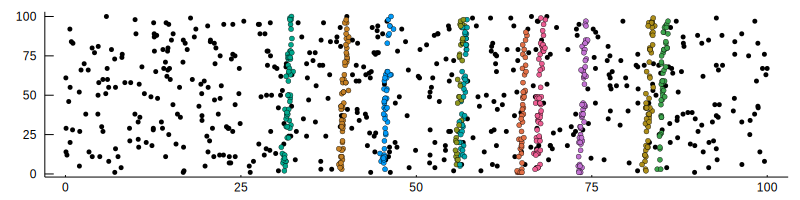

In [68]:
num_noise = 10

# Default parameters
max_time = 100.0
num_neurons = 100
bkgd_rate = 5.0  # 0.5 spikes / second
event_rate = 0.1
amplitude = 50.0  # 0.1 * 50 = 5 spikes / second
seq_duration = 1.0
seq_width = 0.2

gen(;
    seed=1, bkgd_rate=bkgd_rate, 
    amplitude=amplitude, width=seq_width,
) = generate_data(
    seed=seed, max_time=max_time, 
    num_neurons=num_neurons, bkgd_rate=bkgd_rate, 
    event_rate=event_rate, amplitude=amplitude, 
    seq_duration=seq_duration, seq_width=width
)

# Pick seeds
seed_list = collect(1:3)

# Additive noise data 
# --- (num bkgd spk) / (num seq spk)
add_list = range(0.0, 1.0, length=num_noise)

# Dropout noise
# --- seq amplitude
drop_list = range(100.0, 10.0, length=num_noise)

# Jitter noise
# --- seq width
    jitter_list = range(0.0, 3.0, length=num_noise)

data = Dict()
data["add"] = Dict()
data["drp"] = Dict()
data["jit"] = Dict()

for seed in seed_list
    data["add"][seed] = Dict()
    data["drp"][seed] = Dict()
    data["jit"][seed] = Dict()
    
    for i in 1:num_noise
        # Additive noise
        add_pc = add_list[i]
        num_signal = event_rate * amplitude
        noise = add_pc * num_signal
        data["add"][seed][i] = gen(seed=seed, bkgd_rate=noise)
        
        # Dropout noise
        amp = drop_list[i]
        data["drp"][seed][i] = gen(seed=seed, amplitude=amp)
        
        # Jitter noise
        width = jitter_list[i]
        data["jit"][seed][i] = gen(seed=seed, width=width)
    end
end


events, spikes, ids = data["add"][1][10]
plot_raster(spikes, ids)

### PP-Seq Part 1: load models

For each dataset, we'll fit several PP-Seq models with different random seeds:

    (noise type) * (noise level) * (data seed) * (model seed)
    

In [61]:
max_sequence_length = 5.0
model_seed_list = collect(1:3)

function load_model(;
    bkgd_rate=bkgd_rate,
    amplitude=amplitude,
    seq_width=seq_width,
)
    seq_type_proportions = SymmetricDirichlet(1.0, 1)
    amplitude = specify_gamma(
        amplitude,
        (amplitude / 5)^2,
    )
    neuron_response_proportions = SymmetricDirichlet(1.0, num_neurons)
    neuron_response_profile = NormalInvChisq(
        1.0,
        0.0,
        2.0,
        seq_width,
    )
    bkgd_amplitude = specify_gamma(
        bkgd_rate, 
        0.01
    )
    bkgd_proportions = SymmetricDirichlet(1.0, num_neurons)
    return PPSeq(
        max_time,
        max_sequence_length,

        # priors
        event_rate,
        seq_type_proportions,
        amplitude,
        neuron_response_proportions,
        neuron_response_profile,
        bkgd_amplitude,
        bkgd_proportions
    )
end

models = Dict()

for noisetype in ["add", "drp", "jit"]
    models[noisetype] = Dict()
    
    for dseed in seed_list
        models[noisetype][dseed] = Dict()
        
        for i in 1:num_noise
            models[noisetype][dseed][i] = Dict()
            
            for mseed in model_seed_list
                Random.seed!(mseed)
                
                if noisetype == "add"
                    add_pc = add_list[i]
                    num_signal = event_rate * amplitude
                    noise = add_pc * num_signal
                    m = load_model(bkgd_rate=noise)
                elseif noisetype == "drp"
                    amp = drop_list[i]
                    m = load_model(amplitude=amp)
                else  # jit
                    width = jitter_list[i]
                    m = load_model(seq_width=seq_width)
                end
                    
                models[noisetype][dseed][i][mseed] = m
            end
        end
    end
end
println("Models initialized.")

Models initialized.


### PP-Seq Part 2: fit those models!

For every model, run annealed Gibbs! 

In [62]:
num_anneals, max_temp = 5, 50.0
samples_per_anneal, save_every = 1000, 100

#results = Dict()

for noisetype in ["add"]  #, "drp", "jit"]
    results[noisetype] = Dict()
    
    for dseed in seed_list
        results[noisetype][dseed] = Dict()
        
        for i in 1:num_noise
            results[noisetype][dseed][i] = Dict()
            events, spikes, ids = data[noisetype][dseed][i]
            
            for mseed in model_seed_list
                Random.seed!(mseed)
                println("Testing: ", noisetype, dseed, "-", i, "-", mseed)
                
                m = models[noisetype][dseed][i][mseed]
                @time results[noisetype][dseed][i][mseed] =
                    annealed_gibbs!(
                        m, spikes, fill(-1, length(spikes)),
                        num_anneals, samples_per_anneal, max_temp, 0, 1.0, save_every
                    )
                
#                 p = plot_raster(spikes, results[noisetype][dseed][i][mseed][1])
#                 display(p)
                
#                 p1 = plot_raster(spikes, ids)
#                 display(p1)
            end
        end
    end
end
println("Models fit.")



Testing: add1-1-1
  3.078873 seconds (2.72 M allocations: 110.211 MiB, 3.64% gc time)
Testing: add1-1-2
  3.952183 seconds (2.72 M allocations: 110.181 MiB)
Testing: add1-1-3
  3.509115 seconds (2.72 M allocations: 110.195 MiB, 2.89% gc time)
Testing: add1-2-1
  3.965250 seconds (2.98 M allocations: 118.242 MiB)
Testing: add1-2-2
  3.399887 seconds (2.98 M allocations: 118.198 MiB, 2.05% gc time)
Testing: add1-2-3
  4.512258 seconds (2.98 M allocations: 118.191 MiB)
Testing: add1-3-1
  4.896479 seconds (3.26 M allocations: 126.857 MiB, 5.09% gc time)
Testing: add1-3-2
  5.698795 seconds (3.26 M allocations: 126.896 MiB, 12.58% gc time)
Testing: add1-3-3
  3.009984 seconds (3.26 M allocations: 126.852 MiB)
Testing: add1-4-1
  3.849569 seconds (3.55 M allocations: 135.950 MiB, 10.60% gc time)
Testing: add1-4-2
  3.206344 seconds (3.55 M allocations: 135.926 MiB, 2.26% gc time)
Testing: add1-4-3
  4.141196 seconds (3.55 M allocations: 136.003 MiB)
Testing: add1-5-1
  4.554385 seconds (3.8

In [63]:
@save "/home/asd/data/ppseq_noise_tol.jld" models results

In [3]:
d = load("/home/asd/data/ppseq_snr.jld")

  likely near /home/asd/.julia/packages/IJulia/yLI42/src/kernel.jl:52


Dict{String,Any} with 2 entries:
  "models"  => Dict{Any,Any}("add"=>Dict{Any,Any}(4=>Dict{Any,Any}(7=>Dict{Any,…
  "results" => Dict{Any,Any}("add"=>Dict{Any,Any}(4=>Dict{Any,Any}(7=>Dict{Any,…

In [49]:
# repeat for CMF

function bindata(spikes; binsize=0.2)
    datamat = zeros(num_neurons, ceil(Int, max_time/binsize))
    for spk in spikes
        timebin = ceil(Int, spk.timestamp/binsize+eps())
        datamat[spk.neuron, timebin] += 1
    end
    return datamat
end

function plotbindata(datamat; binsize=0.2)
    return heatmap(
        binsize:binsize:max_time,
        1:num_neurons, 
        datamat, 
        size=(800, 200), colorbar=false, 
        c=cgrad([:white, :black], [0, 0.1]),
    )
end

function fit_using_cmf(datamat; binsize=0.2, seed=1000)
    K, L = 1, floor(Int, 2/binsize)
    r = fit_cnmf(
        datamat, L=L, K=K, alg=PGDUpdate,
        max_itr=300, max_time=10,
        constrW=CMF.NonnegConstraint(),
        penaltiesW=[CMF.SquarePenalty(1)],
        penaltiesH=[CMF.AbsolutePenalty(1)],
        check_convergence=false,
        seed=seed
    )
    return r
end
# display(plot(
#     r.time_hist, r.loss_hist, size=(500, 100), legend=false, m=:circle
# ))

function plot_reconstruction(r; binsize=0.2)
    p1 = plotbindata(CMF.tensor_conv(r.W, r.H), binsize=binsize)
    p2 = plot(
        binsize:binsize:max_time, r.H[1, :], seriestype=:bar, legend=false, 
        xlim=(0, max_time), ylim=(0, 1)
    )
    plot!(p2, binsize:binsize:max_time, fill(0.1, length(r.H)), color="red")
    est = extract_events(r)
    plot!(p2, est, fill(0.1, length(est)), seriestype=:scatter, color="green")
    return plot(p1, p2, layout=(2, 1), size=(800, 400))
end

function extract_events(r; binsize=0.2)
    ma, pa = peakprom(r.H[1, :], Maxima(), 3, 0.1)
    return ma * binsize
    #return collect(1:length(r.H))[r.H[1, :] .> 0.05]
end

function eval(events, r::CMF.CNMF_results; binsize=0.2)
    return eval(events, extract_events(r))
end

eval (generic function with 4 methods)

In [50]:
cmf_results = Dict()

for noisetype in ["add", "drp", "jit"]
    cmf_results[noisetype] = Dict()
    
    for dseed in seed_list
        cmf_results[noisetype][dseed] = Dict()
        
        for i in 1:num_noise
            cmf_results[noisetype][dseed][i] = Dict()
            events, spikes, ids = data[noisetype][dseed][i]
            
            for mseed in model_seed_list
                Random.seed!(mseed)
                println("Testing: ", noisetype, dseed, "-", i, "-", mseed)
                
                datamat = bindata(spikes)
                @time r = fit_using_cmf(datamat, seed=mseed)
                cmf_results[noisetype][dseed][i][mseed] = r
                #@show eval(events, extract_events(r))
            end
        end
    end
end
println("Models fit.")

Testing: add1-1-1
 10.980380 seconds (16.63 M allocations: 973.739 MiB, 3.06% gc time)
Testing: add1-1-2
  1.967009 seconds (57.21 k allocations: 234.691 MiB, 0.54% gc time)
Testing: add1-1-3
  2.531601 seconds (57.21 k allocations: 234.691 MiB, 0.63% gc time)
Testing: add1-2-1
  2.603378 seconds (57.21 k allocations: 234.691 MiB, 0.27% gc time)
Testing: add1-2-2
  2.562528 seconds (57.21 k allocations: 234.691 MiB, 0.42% gc time)
Testing: add1-2-3
  3.839593 seconds (57.21 k allocations: 234.691 MiB, 0.13% gc time)
Testing: add1-3-1
  2.313985 seconds (57.21 k allocations: 234.691 MiB, 0.23% gc time)
Testing: add1-3-2
  2.067241 seconds (57.21 k allocations: 234.691 MiB, 0.82% gc time)
Testing: add1-3-3
  2.518830 seconds (57.21 k allocations: 234.691 MiB, 0.21% gc time)
Testing: add1-4-1
  2.144490 seconds (57.21 k allocations: 234.691 MiB, 0.45% gc time)
Testing: add1-4-2
  1.951703 seconds (57.21 k allocations: 234.691 MiB, 0.42% gc time)
Testing: add1-4-3
  1.928847 seconds (57.21

  1.982578 seconds (57.21 k allocations: 234.691 MiB, 0.32% gc time)
Testing: drp1-2-3
  3.021230 seconds (57.21 k allocations: 234.691 MiB, 0.32% gc time)
Testing: drp1-3-1
  2.803218 seconds (57.21 k allocations: 234.691 MiB, 0.48% gc time)
Testing: drp1-3-2
  2.381167 seconds (57.21 k allocations: 234.691 MiB, 0.26% gc time)
Testing: drp1-3-3
  2.219406 seconds (57.21 k allocations: 234.691 MiB, 0.40% gc time)
Testing: drp1-4-1
  2.321728 seconds (57.21 k allocations: 234.691 MiB, 0.20% gc time)
Testing: drp1-4-2
  2.208088 seconds (57.21 k allocations: 234.691 MiB, 0.50% gc time)
Testing: drp1-4-3
  2.250809 seconds (57.21 k allocations: 234.691 MiB, 0.31% gc time)
Testing: drp1-5-1
  2.226415 seconds (57.21 k allocations: 234.691 MiB, 0.24% gc time)
Testing: drp1-5-2
  1.883970 seconds (57.21 k allocations: 234.691 MiB, 0.25% gc time)
Testing: drp1-5-3
  1.963949 seconds (57.21 k allocations: 234.691 MiB, 0.51% gc time)
Testing: drp1-6-1
  1.948284 seconds (57.21 k allocations: 23

  3.228963 seconds (57.21 k allocations: 234.691 MiB, 0.24% gc time)
Testing: jit1-4-2
  2.126823 seconds (57.21 k allocations: 234.691 MiB, 0.28% gc time)
Testing: jit1-4-3
  2.027197 seconds (57.21 k allocations: 234.691 MiB, 0.27% gc time)
Testing: jit1-5-1
  2.168149 seconds (57.21 k allocations: 234.691 MiB, 0.27% gc time)
Testing: jit1-5-2
  2.023170 seconds (57.21 k allocations: 234.691 MiB, 0.61% gc time)
Testing: jit1-5-3
  2.205268 seconds (57.21 k allocations: 234.691 MiB, 0.27% gc time)
Testing: jit1-6-1
  2.713757 seconds (57.21 k allocations: 234.691 MiB, 0.18% gc time)
Testing: jit1-6-2
  3.385857 seconds (57.21 k allocations: 234.691 MiB, 0.29% gc time)
Testing: jit1-6-3
  3.765399 seconds (57.21 k allocations: 234.691 MiB, 0.34% gc time)
Testing: jit1-7-1
  3.298300 seconds (57.21 k allocations: 234.691 MiB, 0.21% gc time)
Testing: jit1-7-2
  3.145953 seconds (57.21 k allocations: 234.691 MiB, 0.22% gc time)
Testing: jit1-7-3
  3.340366 seconds (57.21 k allocations: 23

In [51]:
@save "/home/asd/data/cmf_noise_tol.jld" cmf_results

In [8]:
dcmf = load("/home/asd/data/cmf_snr.jld")

Dict{String,Any} with 1 entry:
  "cmf_results" => Dict{Any,Any}("add"=>Dict{Any,Any}(4=>Dict{Any,Any}(7=>Dict{…

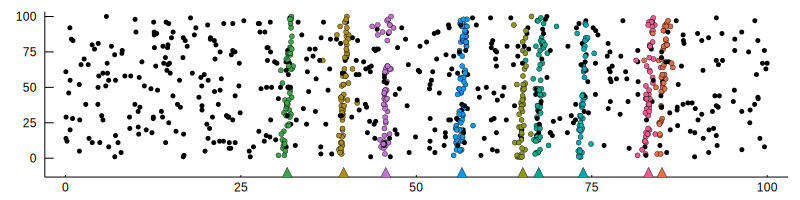

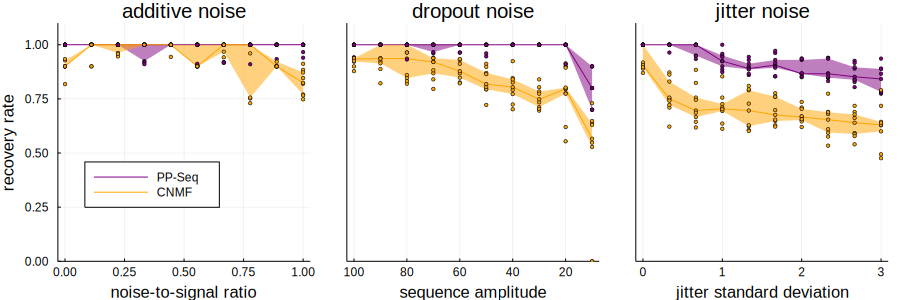

eval(events, (((models[label])[1])[i])[1]) = 1.0


In [75]:
#include("statistical_performance.jl")
model_seed_list = collect(1:3)
#models = d["models"]
#results = d["results"]
#cmf_results = dcmf["cmf_results"]
label = "add"
i = 10

events, spikes, ids = data[label][1][i]
assgn = results[label][1][i][1][1]
display(plot_raster(
    spikes,
    assgn,
    model=models[label][1][i][1]
))

@show eval(events, models[label][1][i][1])

function agg_results(label, r)
    acc = zeros(num_noise, length(seed_list), length(model_seed_list))
    for i = 1:num_noise
        for ds in seed_list
            for ms in model_seed_list
                acc[i, ds, ms] = eval(
                    data[label][ds][i][1], 
                    r[label][ds][i][ms]
                )
            end
        end
    end
    
    # Take median across data / model seeds
    acc_med = [median(acc[i, :, :]) for i in 1:num_noise]
    acc_upp = [quantile(reshape(acc[i, :, :],:), 0.75) for i in 1:num_noise]
    acc_low = [quantile(reshape(acc[i, :, :],:), 0.25) for i in 1:num_noise]
    
    return acc_med, acc_upp, acc_low, acc
end

function gen_snr_plot(label, xvals)
    acc_med, acc_upp, acc_low, acc = agg_results(label, models)
    cacc_med, cacc_upp, cacc_low, cacc = agg_results(label, cmf_results)
    
    p1 = plot(
        xvals, acc_med, 
        ylims=(0.0, 1.1), 
        legend=false,
        color=:purple,
        ribbon=(acc_med-acc_low, acc_upp-acc_med),
        label="PP-Seq"
    )
    plot!(
        p1, xvals, cacc_med,
        ribbon=(cacc_med-cacc_low, cacc_upp-cacc_med),
        label="CNMF", color=:orange
    )
    for ds in seed_list
        for ms in model_seed_list
            plot!(
                p1, 
                xvals, acc[:, ds, ms], 
                seriestype=:scatter,
                color=:purple,
                ms=2,
                label=""
            )
            plot!(
                p1, 
                xvals, cacc[:, ds, ms], 
                seriestype=:scatter,
                color=:orange,
                ms=2,
                label=""
            )
        end
    end
    
    return p1
end

padd = gen_snr_plot("add", add_list)
plot!(padd, 
    title="additive noise", 
    xlabel="noise-to-signal ratio", 
    ylabel="recovery rate",
    legend=:bottomleft
)

pdrp = gen_snr_plot("drp", drop_list)
plot!(pdrp, title="dropout noise", xlabel="sequence amplitude", xflip=true, yticks=[])

pjit = gen_snr_plot("jit", jitter_list)
plot!(pjit, title="jitter noise", xlabel="jitter standard deviation", yticks=[])

p = plot(padd, pdrp, pjit, layout=(1,3), size=(900, 300), bottom_margin=10px)
savefig(p, "/home/asd/pics/seq-mix/noise_tolerance.png")
display(p)

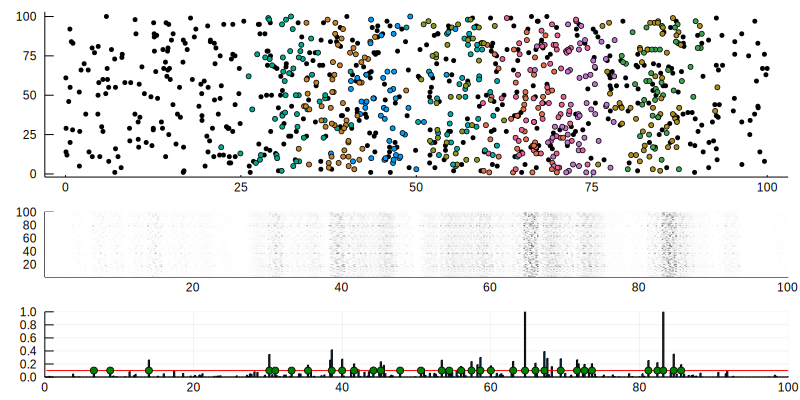

In [76]:
i = 10
label = "jit"

r = cmf_results[label][1][i][1]
events, spikes, ids = data[label][1][i]

p1 = plot_raster(spikes, ids)
p2 = plot_reconstruction(r)
p = plot(p1, p2, layout=(2, 1))
#savefig(p, "/home/asd/pics/seq-mix/cmf_succ.png")
display(p)

### Make a CMF pipeline to initialize events

In [50]:
using CMF
using Peaks

events, spikes, ids = data["add"][1][8]

function bindata(spikes; binsize=0.2)
    datamat = zeros(num_neurons, ceil(Int, max_time/binsize))
    for spk in spikes
        timebin = ceil(Int, spk.timestamp/binsize+eps())
        datamat[spk.neuron, timebin] += 1
    end
    return datamat
end

function extract_events(r; binsize=0.2, windowsize=1.0, thresh=0.1)
    ma, pa = peakprom(
        r.H[1, :], 
        Maxima(), 
        floor(Int, (windowsize/2)/binsize),
        thresh,
    )
    return ma * binsize
end

function cf_initializer(spikes; binsize=0.2, event_window=2.0, seed=nothing)
    # Bin data
    datamat = bindata(spikes, binsize=binsize)
    
    # Fit using a convolutional factorization
    K, L = 1, floor(Int, event_window/binsize)
    r = fit_cnmf(
        datamat, L=L, K=K, alg=PGDUpdate,
        max_itr=200, max_time=Inf,
        constrW=CMF.NonnegConstraint(),
        penaltiesW=[CMF.SquarePenalty(1)],
        penaltiesH=[CMF.AbsolutePenalty(1)],
        check_convergence=false,
        seed=seed
    )
    
    # Extract events
    events = extract_events(r, binsize=binsize, windowsize=event_window)
    
    # Create assignments
    assignments = fill(-1, length(spikes))
    for (i, spk) in enumerate(spikes)
        e = argmin(abs.(events .- spk.timestamp))
        if abs(events[e] - spk.timestamp) <= event_window/2
            assignments[i] = e
        end
    end
    
    return assignments, events
end

init_assgn, init_events = cf_initializer(spikes, binsize=0.15, seed=12, event_window=2.0)
p_true = plot_raster(spikes, ids) 
plot!(p_true, title="data")
 
p_init = plot_raster(spikes, init_assgn, events=zip(1:length(init_events), init_events))
plot!(p_init, title="convolutional factorization initialization")

p = plot(p_true, p_init, layout=(2, 1), size=(800, 400))
savefig(p, "/home/asd/pics/seq-mix/cf_init.png")